# **Seq2Vec Model for classification task using RNN**

---

In this module we will try to predict the country of origin of a given name. Since names are variable length strings, we have to resort to sequence models, in this case a Recurrent Neural Network.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): return glob.glob(path)
print(findFiles('/content/drive/MyDrive/Colab Notebooks/data/names/*.txt'))

['/content/drive/MyDrive/Colab Notebooks/data/names/English.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Polish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Dutch.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Portuguese.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Spanish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Arabic.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/German.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Chinese.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Scottish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Czech.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Italian.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Greek.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Irish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/French.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Japanese.txt', '/content/drive/MyDrive/Colab N

Now we have to clean the data, and read them all from disk.

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/MyDrive/Colab Notebooks/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Indian'][:5])

['Abha', 'Abhilasha', 'Aditi', 'Ahsan', 'Aishwarya']


Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. 

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#print(lineToTensor('Abc'))
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# Creating The Network

---

Now comes the fun part, looking at the network.

We are using a vanilla RNN, so we have two fully-connected, MLP like layers responsible for generating the output and the next hidden state. Although we generate an output at each step, we will only consider the output from the last layer for classification.

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.sigmoid(self.i2h(combined))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [17]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden = rnn(input[1], next_hidden)
output, next_hidden = rnn(input[2], next_hidden)
output, next_hidden = rnn(input[3], next_hidden)
print(output) # Loop over input

tensor([[-3.0723, -3.4251, -2.8610, -3.0828, -2.2950, -2.8929, -2.5975, -2.8563,
         -2.9698, -3.2890, -2.7634, -3.1079, -2.8372, -2.9230, -3.2946, -2.6338,
         -3.1808, -3.6100, -3.1292]], grad_fn=<LogSoftmaxBackward0>)


# Training

---

1) Helper functions for training.

In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 6)


In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, category_tensor.tolist(), '/ line =', line, line_tensor.shape)

category = Vietnamese [17] / line = Banh torch.Size([4, 1, 57])
category = Spanish [4] / line = Castell torch.Size([7, 1, 57])
category = Dutch [2] / line = Nifterick torch.Size([9, 1, 57])
category = English [0] / line = Whittingham torch.Size([11, 1, 57])
category = French [13] / line = Plamondon torch.Size([9, 1, 57])
category = Italian [10] / line = Piazza torch.Size([6, 1, 57])
category = English [0] / line = Winfield torch.Size([8, 1, 57])
category = Italian [10] / line = Nervetti torch.Size([8, 1, 57])
category = Spanish [4] / line = Flores torch.Size([6, 1, 57])
category = Dutch [2] / line = Krusen torch.Size([6, 1, 57])


2) Training the Network
Each loop of training will:

*   Create input and target tensors
*   Create a zeroed initial hidden state
*   Read each letter in and
*   Keep hidden state for next letter
*   Compare final output to target
*   Back-propagate
*   Return the output and loss





In [22]:
criterion = nn.NLLLoss()

In [23]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate) # p = p - learning_rate*p.grad

    return output, loss.item()

In [26]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.3651 Pelaez / Spanish ✓
10000 10% (0m 11s) 2.5573 Pho / Italian ✗ (Vietnamese)
15000 15% (0m 17s) 2.9261 Asturias / Greek ✗ (Spanish)
20000 20% (0m 23s) 1.9606 Bermudez / Spanish ✓
25000 25% (0m 28s) 2.5148 Kaiser / Arabic ✗ (Czech)
30000 30% (0m 34s) 2.5426 Wojewodka / Indian ✗ (Polish)
35000 35% (0m 40s) 2.6917 Katsman / Irish ✗ (Russian)
40000 40% (0m 46s) 3.0195 Rompu / Indian ✗ (Dutch)
45000 45% (0m 52s) 2.5346 Victor / German ✗ (Czech)
50000 50% (0m 57s) 1.8697 Larue / French ✓
55000 55% (1m 3s) 0.6320 Zouvelekis / Greek ✓
60000 60% (1m 9s) 1.5664 Sum / Vietnamese ✗ (Chinese)
65000 65% (1m 14s) 2.2294 Reilly / Scottish ✗ (Irish)
70000 70% (1m 20s) 2.7820 Seymour / German ✗ (English)
75000 75% (1m 26s) 1.8532 Grzeskiewicz / Spanish ✗ (Polish)
80000 80% (1m 32s) 1.2688 Stawski / Polish ✓
85000 85% (1m 38s) 1.4049 Paternoster / German ✓
90000 90% (1m 43s) 1.9826 Vela / Indian ✗ (Spanish)
95000 95% (1m 49s) 0.4980 Dubicki / Polish ✓
100000 100% (1m 55s) 4.0902 Jones

# Results

---



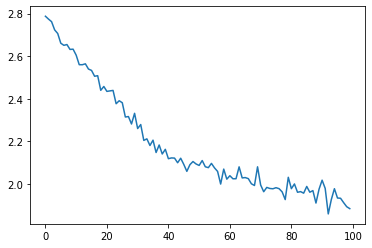

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

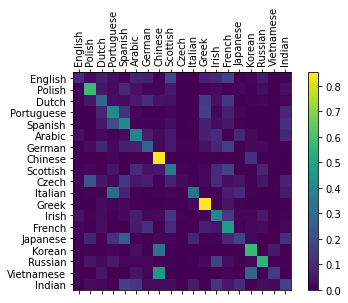

In [28]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# **Deployment**

---



In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Braznev')


> Braznev
(-0.23) Russian
(-3.46) Dutch
(-3.84) Spanish
